In [20]:
#Importing the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, TensorDataset
import pandas as pd
import numpy as np
import time
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score , precision_score, confusion_matrix
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [63]:
df = pd.read_csv('creditcard.csv')
#print count of column Class
print(df['Class'].value_counts())

X = df.drop('Class', axis=1)
y = df['Class']
X = X.values
y = y.values

#Splitting the data into training and testing data
# Utiliser train_Test_split de scikit-learn
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
batch_size = 2**11


Class
0    284315
1       492
Name: count, dtype: int64


In [54]:

class CustomDataSet(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y      
    
#Converting the data into tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train = CustomDataSet(X_train, y_train)
X_test = CustomDataSet(X_test, y_test) 

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size)


In [64]:
# Calcul des poids de classe pour gérer un dataset déséquilibré
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.float32), 
                                num_samples=len(sample_weights), 
                                replacement=True)

# Création des datasets d'entraînement et de test avec conversion explicite en float32
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.float32))

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1000, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=1000)


In [55]:
class MyFlexibleModel(nn.Module):
    def __init__(self, in_features, hidden_layers, in_feature_hidden_layers, out_features, dropout_rate=0.5):
        super(MyFlexibleModel, self).__init__()
        
        # Create a list to store the layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features, in_feature_hidden_layers))
        
        # Add the hidden layers
        for i in range(1, hidden_layers):
            self.layers.append(nn.Linear(in_feature_hidden_layers, in_feature_hidden_layers))
            self.layers.append(nn.BatchNorm1d(in_feature_hidden_layers))
            self.layers.append(nn.ReLU())  
        
        # Ajouter la couche de sortie
        self.layers.append(nn.Linear(in_feature_hidden_layers, out_features))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            # x = self.dropout(x)
        
        x = self.layers[-1](x)
        x = torch.sigmoid(x)
        return x




In [50]:
def confusion_matrix_function(classes, confusion_matrix):
    print("Confusion Matrix")
    # Créer les en-têtes de la table avec les classes prédites
    headers = [""] + [f"Predicted: {cls}" for cls in classes.index]

    # Créer les lignes de la table avec les valeurs de la matrice de confusion
    rows = [
        [f"Class: {classes.index[i]} - {classes[i]}"] + list(confusion_matrix[i])
        for i in range(len(classes))
    ]

    # Afficher la table
    print(tabulate(rows, headers=headers, tablefmt="grid"))

In [65]:
model = MyFlexibleModel(X.shape[1], 5,40, 1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 30  # Number of epochs
train_loss = []
test_loss = []

start_time = time.time()

for epoch in range(epochs):
    model.train()
    losses_train = 0
    correct_predictions, total_predictions = 0, 0 
    
    y_pred_train = []
    y_true_train = []
    for inputs, labels in train_loader:
        
        optimizer.zero_grad()  # Reset gradients to zero
        outputs_train = model(inputs)  # Pass data through the model
        loss = criterion(outputs_train.squeeze(), labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Cumulate loss from each bach
        losses_train += loss.item()
        
        # Calculate the accuracy
          #Apply sigmoid to the outputs cause outputs are logits
        predictions = (outputs_train.squeeze()  >= 0.5).float()  # convert probabilities to binary predictions
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0) 
        
        # Append the predictions to the list
        y_pred_train.extend(predictions.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
    
    losses = losses_train / len(train_loader)
    train_loss.append(losses)
    
    train_acc = correct_predictions / total_predictions
    #Evaluation Mode
    model.eval() 
    
    y_pred_test, y_true_test = [], []
    
    with torch.no_grad():
        #loss and accuracy for the validation set
        losses_test = 0
        test_acc = 0
        
        correct_predictions_label = 0
        total_predictions = 0
        
        for inputs_test, labels_test in test_loader:
            outputs_labels = model(inputs_test)
            loss = criterion(outputs_labels.squeeze(), labels_test)
            losses_test += loss.item()
            
            prediction_test = (outputs_labels.squeeze() >= 0.5).float()

            correct_predictions_label += (prediction_test == labels_test).sum().item()
            total_predictions += labels_test.size(0)
            
            y_pred_test.extend(prediction_test.numpy())
            y_true_test.extend(labels_test.numpy())
        test_acc = correct_predictions_label / total_predictions
        
        losses_test = losses_test / len(test_loader)
        test_loss.append(losses_test)

    print('='*100)   
    print(f'Epoch: {epoch+1} - Loss Train : {losses:4f} - Loss Val : {losses_test:.4f} - Acc Train : {train_acc:.4f} - Acc Val : {test_acc:.4f}')
    # confusion_matrix_function(df['Class'].value_counts(), confusion_matrix(y_true_test, y_pred_test))
    #print f1 score val & train
    print(f'F1 Score Train: {f1_score(y_true_train, y_pred_train):.4f} - F1 Score Val: {f1_score(y_true_test, y_pred_test):.4f}')
        
end_time = time.time() 

print(f"Training time: {end_time - start_time}s")
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train', c='blue')
ax.plot(test_loss, label='Test', c='red')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

Epoch: 1 - Loss Train : 0.737802 - Loss Val : 0.7067 - Acc Train : 0.5032 - Acc Val : 0.0013
F1 Score Train: 0.5389 - F1 Score Val: 0.0026
Epoch: 2 - Loss Train : 0.721616 - Loss Val : 0.7092 - Acc Train : 0.5031 - Acc Val : 0.0013
F1 Score Train: 0.5392 - F1 Score Val: 0.0026
Epoch: 3 - Loss Train : 0.712956 - Loss Val : 0.7116 - Acc Train : 0.5039 - Acc Val : 0.0013
F1 Score Train: 0.5407 - F1 Score Val: 0.0026
Epoch: 4 - Loss Train : 0.706413 - Loss Val : 0.7122 - Acc Train : 0.5020 - Acc Val : 0.0013
F1 Score Train: 0.5408 - F1 Score Val: 0.0026
Epoch: 5 - Loss Train : 0.700951 - Loss Val : 0.7142 - Acc Train : 0.5049 - Acc Val : 0.0013
F1 Score Train: 0.5494 - F1 Score Val: 0.0026
Epoch: 6 - Loss Train : 0.698450 - Loss Val : 0.7128 - Acc Train : 0.5052 - Acc Val : 0.0013
F1 Score Train: 0.5492 - F1 Score Val: 0.0026
Epoch: 7 - Loss Train : 0.696457 - Loss Val : 0.7134 - Acc Train : 0.5073 - Acc Val : 0.0013
F1 Score Train: 0.5527 - F1 Score Val: 0.0026
Epoch: 8 - Loss Train : 0.6

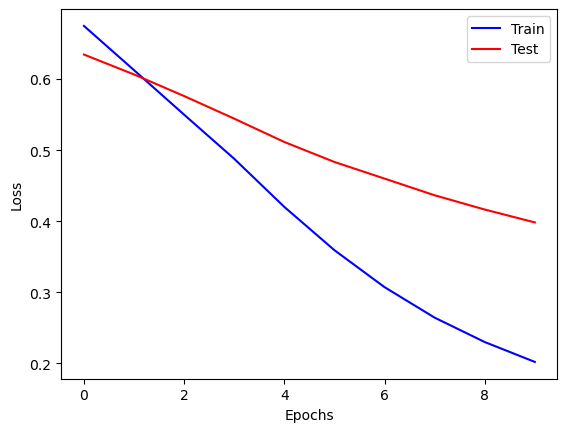

In [41]:

fig, ax = plt.subplots()
ax.plot(train_loss, label='Train', c='blue')
ax.plot(test_loss, label='Test', c='red')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()